In [1]:
import pandas as pd
import numpy as np
from coffea import util
import itertools
import os
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")


## analysis categories

In [2]:
# # analysis categories #
# # ttagcats = ["AT&Pt", "at", "pret", "0t", "1t", ">=1t", "2t", ">=0t"] 
# ttagcats = ["at", "pret", "2t"]
# btagcats = ["0b", "1b", "2b"]
# ycats = ['cen', 'fwd']

# anacats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]
# label_dict = {i: label for i, label in enumerate(anacats)}
# label_to_int_dict = {label: i for i, label in enumerate(anacats)}
# label_to_int_dict
# signal_cats = [ i for label, i in label_to_int_dict.items() if '2t' in label]
# pretag_cats = [ i for label, i in label_to_int_dict.items() if 'pre' in label]
# signal_cats, pretag_cats

In [6]:
IOVs = ['2016']

# analysis categories #

label_dict = util.load(f'../outputs/QCD_{IOVs[0]}.coffea')['analysisCategories']
label_to_int_dict = {label: i for i, label in label_dict.items()}

signal_cats = [ i for label, i in label_to_int_dict.items() if '2t' in label]
pretag_cats = [ i for label, i in label_to_int_dict.items() if 'pre' in label]




In [7]:
# label_dict

## scale factors and IOV

In [9]:


lumi = {
    "2016APV": 19800.,
    "2016": 16120., #35920 - 19800
    "2016all": 35920,
    "2017": 41530.,
    "2018": 59740.
}

t_BR = 0.6741
ttbar_BR = 0.4544 #PDG 2019
ttbar_xs1 = 831.76 * (0.09210) #pb For ttbar mass from 700 to 1000
ttbar_xs2 = 831.76 * (0.02474) #pb For ttbar mass from 1000 to Inf
toptag_sf = 0.9
toptag_kf = 1.0 #0.7
qcd_xs = 13700000.0 #pb From https://cms-gen-dev.cern.ch/xsdb



## save plots

In [10]:
directories = [
    'images/png/closureTestQCD/2016all',
    'images/png/closureTestQCD/2016APV',
    'images/png/closureTestQCD/2016',
    'images/png/closureTestQCD/2017',
    'images/png/closureTestQCD/2018',
    'images/pdf/closureTestQCD/2016all',
    'images/pdf/closureTestQCD/2016APV',
    'images/pdf/closureTestQCD/2016',
    'images/pdf/closureTestQCD/2017',
    'images/pdf/closureTestQCD/2018',
]


for path in directories:
    if not os.path.exists(path):
        os.makedirs(path)

## coffea files

In [11]:
tagger='DeepAK8 top tagger'
# tagger='CMS top tagger'


coffea_dir = '../outputs/'
coffeaFiles = {
    "unweighted": {
        "2016APV": coffea_dir+'QCD_2016APV.coffea',
        "2016": coffea_dir+'QCD_2016.coffea',
        "2017": '',
        "2018": ''
    },
    "weighted": {
        "2016APV": coffea_dir+'QCD_2016APV_bkgest.coffea',
        "2016": coffea_dir+'QCD_2016_bkgest.coffea',
        "2017": '',
        "2018": ''
    }
}




/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


(900.0, 6000.0)

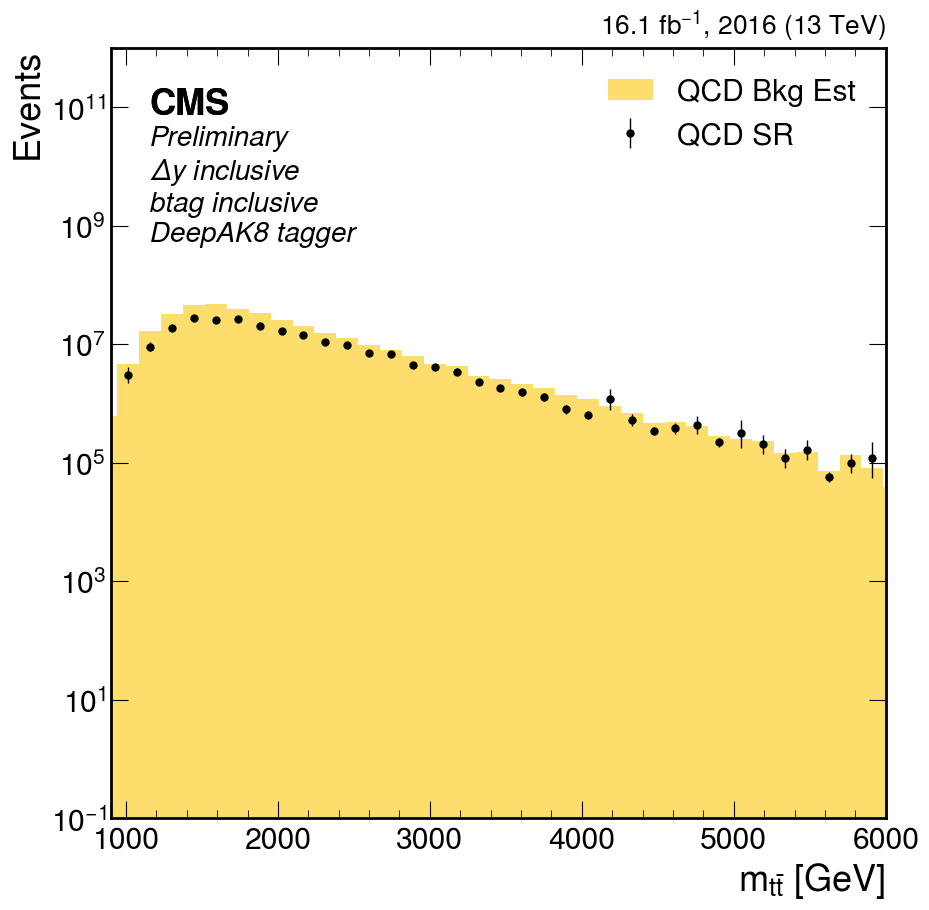

In [12]:
IOV = '2016'

sig = util.load(coffeaFiles['unweighted'][IOV])
bkg = util.load(coffeaFiles['weighted'][IOV])

qcdsf = {
    'sig': lumi[IOV] * qcd_xs / sig['cutflow']['sumw'],
    'bkg': lumi[IOV] * qcd_xs / bkg['cutflow']['sumw'],
}

hsig = sig['ttbarmass'][{'anacat':signal_cats}][{'anacat':sum}] * qcdsf['sig']
hbkg = bkg['ttbarmass'][{'anacat':pretag_cats}][{'anacat':sum}] * qcdsf['bkg']


hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi[IOV]/1000), year=IOV, loc=2, fontsize=20)
hep.cms.text('Preliminary'+'\n'+r'$\Delta y$ inclusive'+'\n'+r'btag inclusive''\n'+r'DeepAK8 tagger', loc=2, fontsize=20)

hep.histplot(hsig, histtype='errorbar', color='black', label='QCD SR')
hep.histplot(hbkg, histtype='fill', color='xkcd:pale gold', label='QCD Bkg Est')


plt.legend()
plt.ylabel('Events')
plt.yscale('log')
plt.ylim(1e-1, 1e12)
plt.xlim(900,6000)
